# ARIMA - SARIMA

ARIMA est l’un des modèles de prévision de séries chronologiques les plus classiques. Au cours du processus de modélisation, nous voulons principalement trouver 3 paramètres. Terme d'auto-régression (AR), à savoir les décalages de la valeur précédente; Terme intégral (I) pour la différenciation non stationnaire et moyenne mobile (MA) pour le terme d'erreur.


## L'objectif pour ce tp est de :

- Comprendre ARIMA, SARIMA
- Examiner les tests nécessaires dont ARIMA a besoin pour vérifier la stationnarité
- Trouver un ensemble de paramètres à partir de tests statistiques et de visualisations

## La structure de TP :

- Introduction d'ARIMA
- Décomposer les ts
- Stationnariser les données
- Interpréter ACF et PACF
- Déterminer p, d, q
- Ajout de la saisonnalité: SARIMA



In [1]:
import warnings 
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd 
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab style plot
import seaborn as sns # affichage
import statsmodels.api as sm # modèle stat contenant le modèle ARIMA

color = sns.color_palette()
sns.set_style('darkgrid')


- Lecture du fichier csv et conversion du champ date.

In [2]:
train = pd.read_csv('./train.csv')
train['date'] = pd.to_datetime(train['date'], format="%Y-%m-%d")

train.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


- Description de la structure du fichier

## Préparation et description des données 



$\bullet $ Ajouter 4 colonnes, l'année, le numéro du mois, le jour dans l'année et le jour de la semaine dans les données train_df.


In [4]:
# Entrainement du modèle pour store == 1 et item == 1
# Sélection des données
train_df = train[train['store']==1]
train_df = train_df[train['item']==1]

train_df['year'] = train['date'].dt.year
train_df['month'] = train['date'].dt.year
train_df['day'] = train['date'].dt.year
train_df['weekday'] = train['date'].dt.weekday

train_df.head()


print(train_df)

           date  store  item  sales  year  month   day  weekday
0    2013-01-01      1     1     13  2013   2013  2013        1
1    2013-01-02      1     1     11  2013   2013  2013        2
2    2013-01-03      1     1     14  2013   2013  2013        3
3    2013-01-04      1     1     13  2013   2013  2013        4
4    2013-01-05      1     1     10  2013   2013  2013        5
...         ...    ...   ...    ...   ...    ...   ...      ...
1821 2017-12-27      1     1     14  2017   2017  2017        2
1822 2017-12-28      1     1     19  2017   2017  2017        3
1823 2017-12-29      1     1     15  2017   2017  2017        4
1824 2017-12-30      1     1     27  2017   2017  2017        5
1825 2017-12-31      1     1     23  2017   2017  2017        6

[1826 rows x 8 columns]


$\bullet$ **Décrire les données**

In [5]:
train_df.describe()

,store,item,sales,year,month,day,weekday
count,1826.0,1826.0,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000
mean,1.0,1.0,19.971522,2015.000548,2015.000548,2015.000548,3.001643
std,0.0,0.0,6.741022,1.414407,1.414407,1.414407,1.999862
min,1.0,1.0,4.000000,2013.000000,2013.000000,2013.000000,0.000000
25%,1.0,1.0,15.000000,2014.000000,2014.000000,2014.000000,1.000000
50%,1.0,1.0,19.000000,2015.000000,2015.000000,2015.000000,3.000000
75%,1.0,1.0,24.000000,2016.000000,2016.000000,2016.000000,5.000000
max,1.0,1.0,50.000000,2017.000000,2017.000000,2017.000000,6.000000


Il y a peu de variances pour year, month, day, weekday


## Affichage de la série chronologique

Pour commencer, nous voulons décomposer les données pour séparer la saisonnalité, la tendance et les résidus. 

Utilisons une fonction dans statsmodels pour nous aider à trouver la trendance.

$\bullet$ Affichage de toutes les données

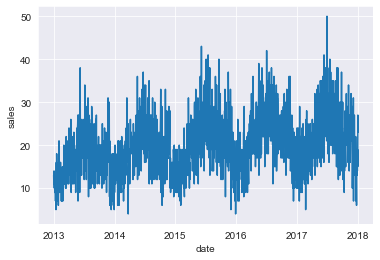

In [7]:
sns.lineplot(x="date", y="sales",legend = 'full' , data=train_df)

$\bullet$ Afficher les 28 permières valeurs

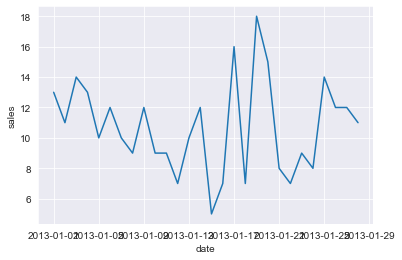

In [8]:
sns.lineplot(x="date", y="sales",legend = 'full' , data=train_df[:28])

$\bullet$ Afficher les boxplot sur les jours de la semaine, les mois

(fonction sns.boxplot)

$\bullet$ Commenter

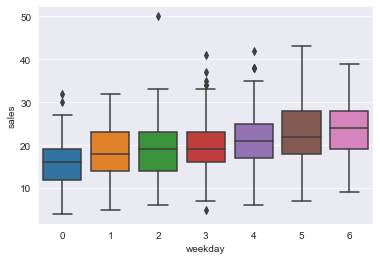

In [9]:
sns.boxplot(x="weekday", y="sales", data=train_df)

- Il y a une croissance des ventes du jour 0 au jour 6
- Si on considère que Lundi=0, et que 6=dimanche, les achats ont tendance à augmenter le wkd. 
- Il y a des outliers pour 1, 2, 3 et 4.

$\bullet$ Transformer 'date' en index,

$\bullet$ Transformer 'sales' en float

In [10]:
train_df = train_df.set_index('date')
train_df['sales'] = train_df['sales'].astype('float')

train_df.head()

,store,item,sales,year,month,day,weekday
date,,,,,,,
2013-01-01,1,1,13.0,2013,2013,2013,1
2013-01-02,1,1,11.0,2013,2013,2013,2
2013-01-03,1,1,14.0,2013,2013,2013,3
2013-01-04,1,1,13.0,2013,2013,2013,4
2013-01-05,1,1,10.0,2013,2013,2013,5


## Décomposition selon un modèle additif

Décomposition de la série (tendance, saisonnalité, erreur) en utilisant statsmodels et seasonal_decompose

(hypothèse période sur 365 jours)

- La tendance est croissante => série non stationnaire.
- Il y a une saisonnalité annuelle.
- Il y a beaucoup de résidus.

<Figure size 432x288 with 0 Axes>

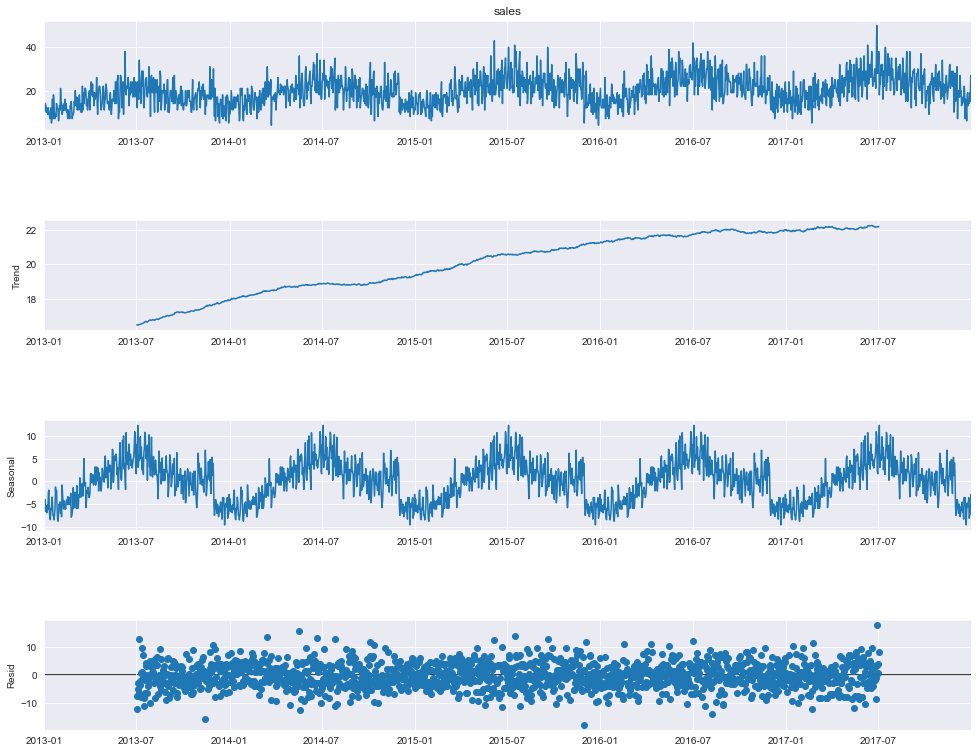

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(train_df['sales'], freq=365)

fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(15, 12)

## Stationnarisation de la série

Pourquoi est-ce important ? Lors de l'exécution d'une régression linéaire, l'hypothèse est que toutes les observations sont indépendantes les unes des autres. 
Dans une série chronologique, cependant, nous savons que les observations dépendent du temps. Il s'avère que beaucoup de bons résultats valent pour les variables aléatoires indépendantes (loi des grands nombres et théorème limite central), pour les variables aléatoires stationnaires. Donc, en rendant les données stationnaires, nous pouvons réellement appliquer des techniques de régression à cette variable dépendante du temps.

Vous pouvez vérifier la stationnarité d'une série chronologique de deux manières. Le premier est en regardant les données. En visualisant les données, il devrait être facile d'identifier un changement de moyenne ou de variation des données. 

Visuellement, la série ne semble pas stationnaire.

En utilisant le test de Dickey-Fuller, il est possible de dire si la série est stationnaire ou non. Si la «statistique de test» est supérieure à la «valeur critique», la série temporelle est stationnaire. 

Nous utiliserons la librairie python statsmodels.

https://www.statsmodels.org/stable/index.html


La fonction suivante permet d'afficher une moyenne mobile, une variance (mobile), les données et le résutat d'un test de stationnarité (Dicker-Fuller)

In [13]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries, window = 12, cutoff = 0.01):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Resultats du Test de Dickey-Fuller :')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistique','p-value','#Lags utilisés','Nombre d observations utilisées'])
    for key,value in dftest[4].items():
        dfoutput['Valeur critique (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. La série est vraisemblablement stationnaire.' % pvalue)
    else:
        print('p-value = %.4f. La série est vraisemblablement non stationnaire.' % pvalue)
    
    print(dfoutput)

$\bullet$  Tester la stationnarité et commenter (choisir un fenêtre de 30)

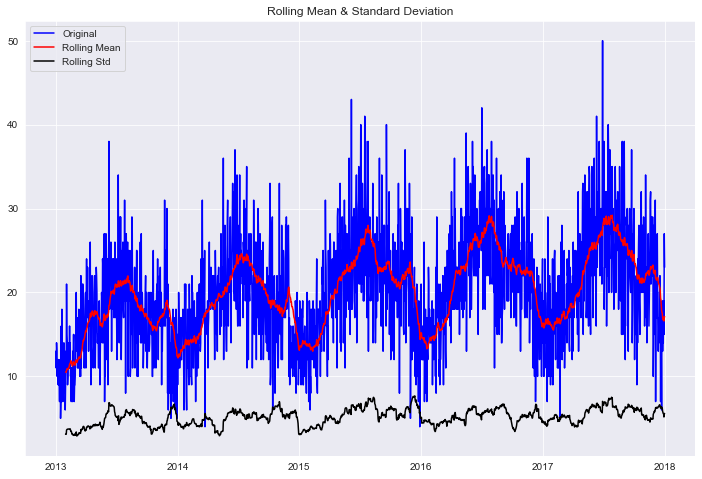

Resultats du Test de Dickey-Fuller :
p-value = 0.0361. La série est vraisemblablement non stationnaire.
Test Statistique                     -2.987278
p-value                               0.036100
#Lags utilisés                       20.000000
Nombre d observations utilisées    1805.000000
Valeur critique (1%)                 -3.433978
Valeur critique (5%)                 -2.863143
Valeur critique (10%)                -2.567623
dtype: float64


In [14]:
test_stationarity(train_df['sales'],30)

- La série n'est pas stationnaire d'après le plot. 
- p-value = 0.036. Si on utilise 5%, cette série peut-être considérée comme stationnaire.
- Mais, comme on a remarqué qu'il y a une tendance croissante, alors on devrait utiliser 1%:
- Le test de Dickey-Fuller :  p-value > 0.01 donc la série est non stationnaire pour 1%

$\bullet$ Appliquer ce même test sur la série des différence d'ordre 1

$\bullet$ Commenter (comparer avec le résultat précédent)

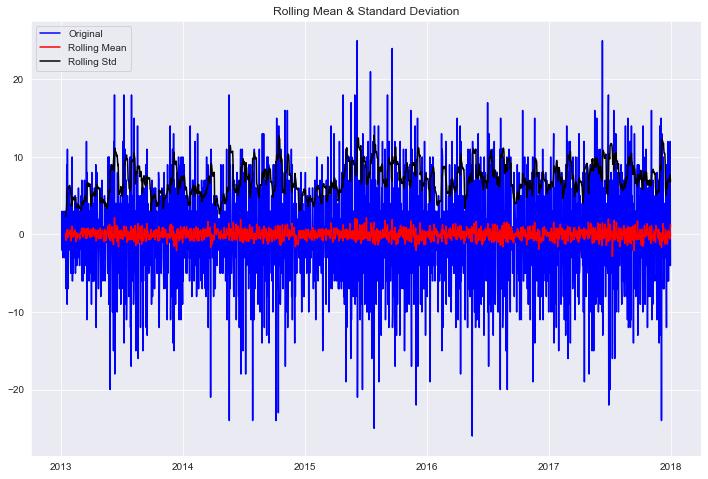

Resultats du Test de Dickey-Fuller :
p-value = 0.0000. La série est vraisemblablement stationnaire.
Test Statistique                  -1.520810e+01
p-value                            5.705031e-28
#Lags utilisés                     2.000000e+01
Nombre d observations utilisées    1.804000e+03
Valeur critique (1%)              -3.433980e+00
Valeur critique (5%)              -2.863143e+00
Valeur critique (10%)             -2.567624e+00
dtype: float64


In [15]:
first_diff = train_df.sales - train_df.sales.shift(1)
first_diff = first_diff.dropna(inplace = False)
test_stationarity(first_diff, window = 12)

- p-value = 5.705031e-28. 
- Après une différence d'ordre 1, il y a une forte probabilité que la série soit stationnaire.



## ACF et PACF

L'autocorrélation partielle au décalage $k$ est la corrélation obtenue après suppression de l'effet des éventuelles corrélations dues aux termes ayant des retards plus courts.



À partir du graphique d'autocorrélation, nous pouvons dire si nous devons ou non ajouter des termes MA. Nous savons, à partir du graphique d'autocorrélation partielle, que nous devons ajouter des termes AR.



Références:

https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/

$\bullet$ Afficher et commenter l'ACF et le PACF sur la série temporel train_df.sales

plot_acf et plot_pacf a pour première entrée les valeurs de la série

https://www.statsmodels.org/dev/generated/statsmodels.graphics.tsaplots.plot_acf.html

https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_pacf.html

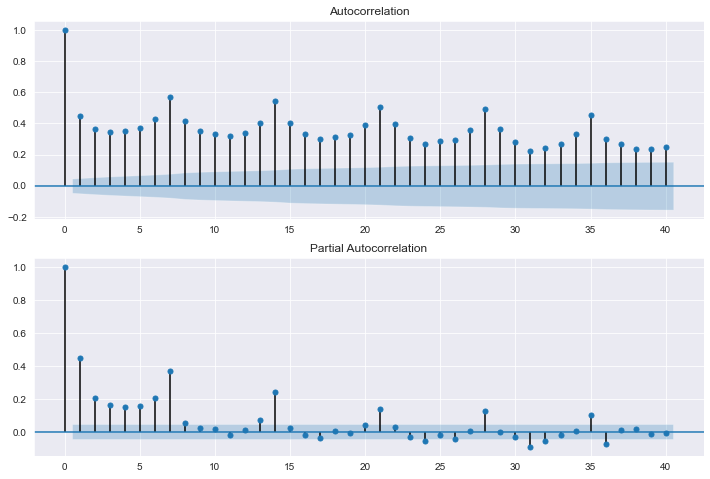

In [17]:
import statsmodels.api as sm

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train_df.sales, lags=40, ax=ax1) 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train_df.sales, lags=40, ax=ax2)# 

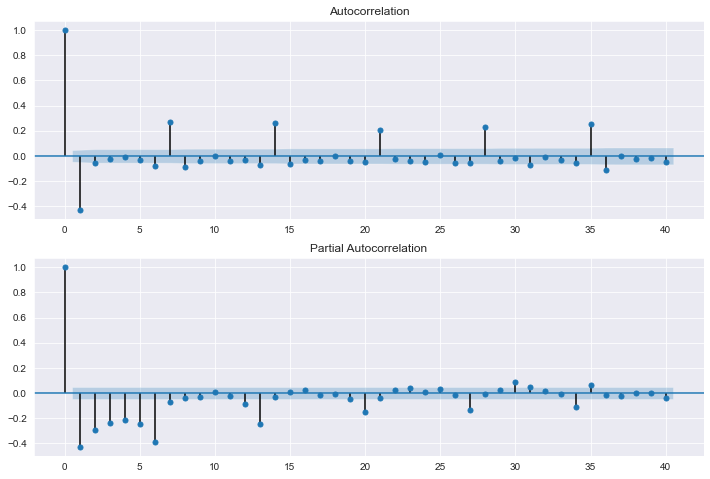

In [18]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(first_diff, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(first_diff, lags=40, ax=ax2)


- ACF et PACF ont des éléments périodiques de période = 7. Donc il y a une saisonnalité d'une semaine. 
- Il faut donc travailler avec SARIMA.

- l'autocorrelation de la période saisonnière(7) est negative, on doit donc considérer l'ajout un terme SMA au modèle.
d'après https://faculty.fuqua.duke.edu/~rnau/Decision411_2007/seasarim.htm

- ACF devient majoritairement nulle à partir de l'ordre 1 sauf pour les ordres multiples de 7.
- PACF décroit exponentiellement mais a des valeurs non nulles écartées de 7. 



Construire le modèle - Déterminer p, d, q



Référence:

https://www.researchgate.net/post/How_does_one_determine_the_values_for_ARp_and_MAq
https://stats.stackexchange.com/questions/281666/how-does-acf-pacf-identify-the-order-of-ma-and-ar-terms/281726#281726
https://stats.stackexchange.com/questions/134487/analyse-acf-and-pacf-plots?rq=1

- D'après PACF, on choisit p=6 pour AR puisque après un lag de 6, presque tous les termes deviennent nuls.


$\bullet$ Choisir des valeurs de p, d et q.

In [55]:
p = 6
d = 1
q = 0
arima_mod6 = sm.tsa.ARIMA(train_df.sales, (p,d,q)).fit(disp=False)
print(arima_mod6.summary())

C:\Users\33645\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\33645\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


                             ARIMA Model Results                              
Dep. Variable:                D.sales   No. Observations:                 1825
Model:                 ARIMA(6, 1, 0)   Log Likelihood               -5597.668
Method:                       css-mle   S.D. of innovations              5.195
Date:                Mon, 07 Dec 2020   AIC                          11211.335
Time:                        20:19:16   BIC                          11255.410
Sample:                    01-02-2013   HQIC                         11227.594
                         - 12-31-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0039      0.025      0.152      0.879      -0.046       0.054
ar.L1.D.sales    -0.8174      0.022    -37.921      0.000      -0.860      -0.775
ar.L2.D.sales    -0.7497      0.026    -

La constante ne semble pas significative.

Analyser le résultat

Pour voir comment notre premier modèle fonctionne, nous pouvons tracer la distribution résiduelle. Voir si c'est normal dist. Et l'ACF et PACF. Pour un bon modèle, nous voulons voir que le résidu est une distribution normale. Et ACF, PACF n'a pas de termes significatifs.

NormaltestResult(statistic=16.426383166496436, pvalue=0.00027105424711835563)


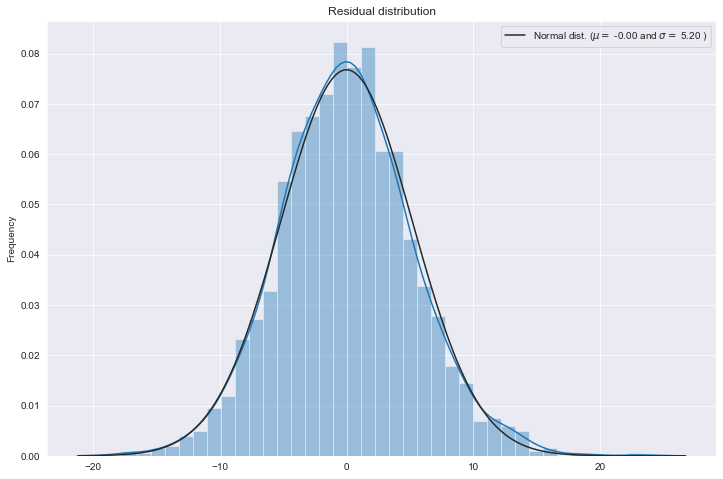

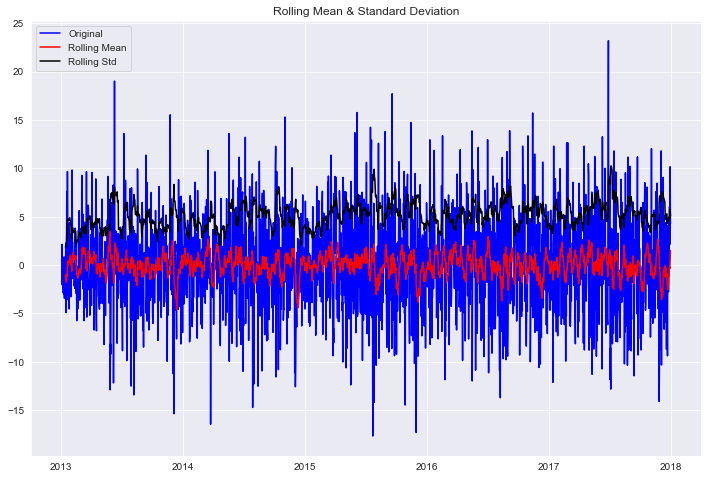

Resultats du Test de Dickey-Fuller :
p-value = 0.0000. La série est vraisemblablement stationnaire.
Test Statistique                  -1.091980e+01
p-value                            1.045017e-19
#Lags utilisés                     2.000000e+01
Nombre d observations utilisées    1.804000e+03
Valeur critique (1%)              -3.433980e+00
Valeur critique (5%)              -2.863143e+00
Valeur critique (10%)             -2.567624e+00
dtype: float64


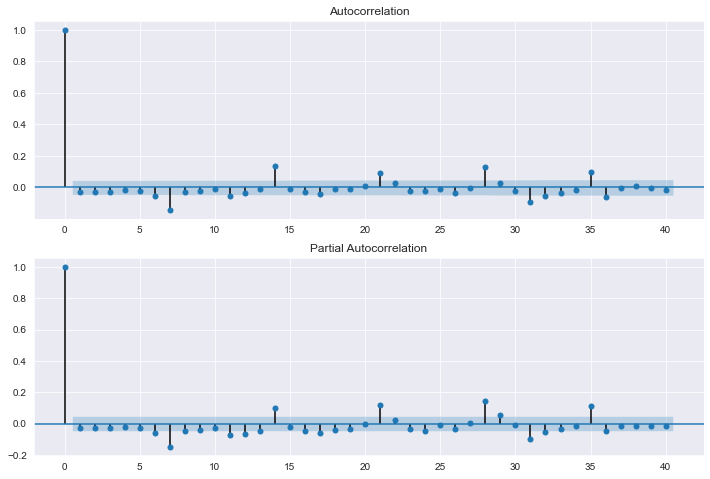

In [56]:
from scipy import stats
from scipy.stats import normaltest

resid = arima_mod6.resid
print(normaltest(resid))
# returns a 2-tuple of the chi-squared statistic, and the associated p-value. the p-value is very small, meaning
# the residual is not a normal distribution

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(resid)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')

test_stationarity(arima_mod6.resid,12)


# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(arima_mod6.resid, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(arima_mod6.resid, lags=40, ax=ax2)




- Les résidus suivent bien une distribution normale.
- Le test de Dickey Fuller indique que la série est stationaire (p-value est de l'ordre de 10^-10)
- Les coefficients d'ACF et de PACF de période 7 sont significativement non nuls => ajouter la saisonalité

# Affichage d'une prédiction

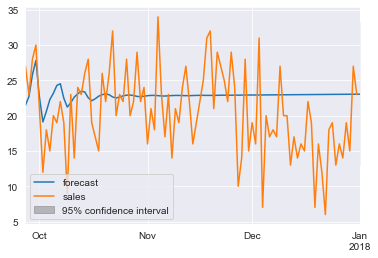

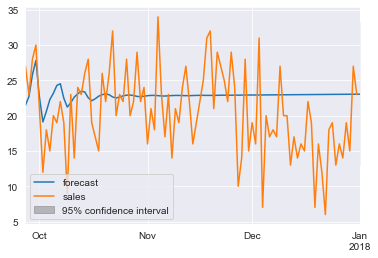

In [75]:
start_index = 1730
end_index = 1826
arima_mod6.plot_predict(start = start_index, end= end_index, dynamic= True)  




Bien que le graphique ressemble beaucoup à une distribution normale. Mais cela a échoué au test. Nous constatons également une corrélation récurrente dans ACF et PACF. Nous devons donc faire face à la saisonnalité.

Considérez la saisonnalité affectée par SARIMA

https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html
https://barnesanalytics.com/sarima-models-using-statsmodels-in-python

In [83]:
sarima_mod6 = sm.tsa.statespace.SARIMAX(train_df.sales, trend='n', order=(6,1,1), seasonal_order=(0, 1,1,7)).fit()
print(sarima_mod6.summary())

C:\Users\33645\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\33645\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


                                     SARIMAX Results                                     
Dep. Variable:                             sales   No. Observations:                 1826
Model:             SARIMAX(6, 1, 1)x(0, 1, 1, 7)   Log Likelihood               -5394.553
Date:                           Mon, 07 Dec 2020   AIC                          10807.106
Time:                                   20:41:11   BIC                          10856.656
Sample:                               01-01-2013   HQIC                         10825.388
                                    - 12-31-2017                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0104      0.033     -0.312      0.755      -0.075       0.055
ar.L2         -0.0419      0.030     -1.378

NormaltestResult(statistic=18.744708434161517, pvalue=8.504294301743298e-05)


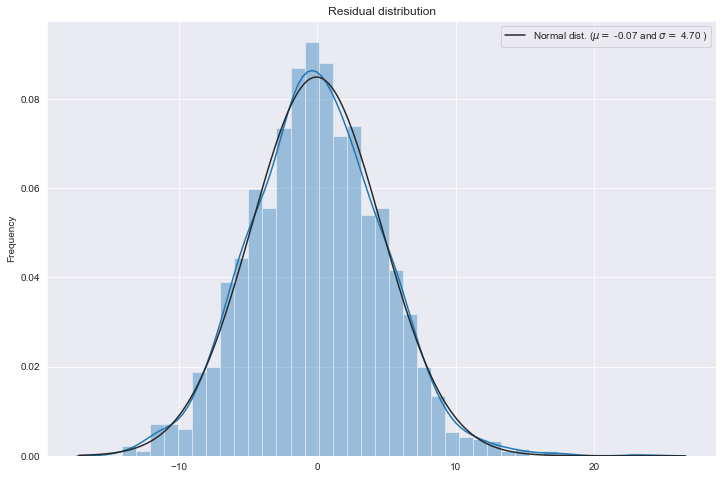

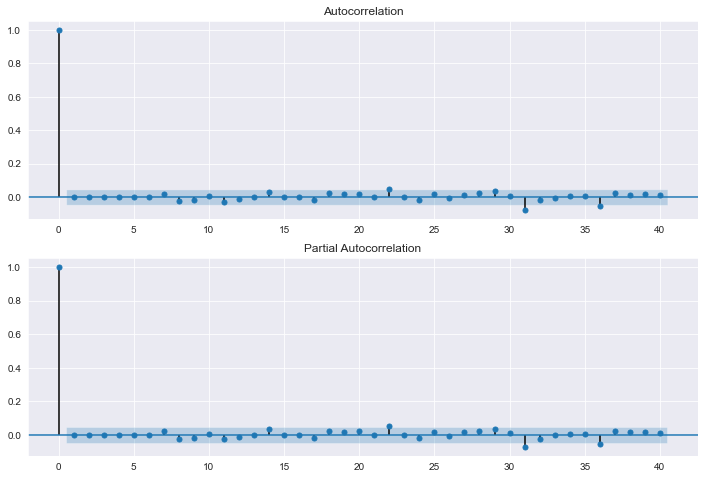

In [84]:
resid = sarima_mod6.resid
print(normaltest(resid))

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(resid)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')


# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(sarima_mod6.resid, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(sarima_mod6.resid, lags=40, ax=ax2)

- Bruit blanc
- Il ne reste presque plus de coefficients non nuls.

Faire des prévisions et des évaluations

Prendre les 30 derniers jours d’entraînement définis comme données de validation

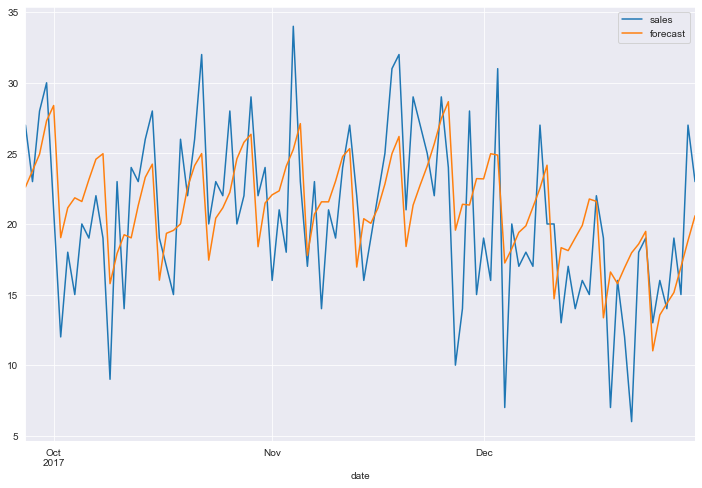

In [85]:
start_index = 1730
end_index = 1826
train_df['forecast'] = sarima_mod6.predict(start = start_index, end= end_index)  
train_df[start_index:end_index][['sales', 'forecast']].plot(figsize=(12, 8))

In [86]:
def smape_kun(y_true, y_pred):
    mape = np.mean(abs((y_true-y_pred)/y_true))*100
    smape = np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) + np.abs(y_true))).fillna(0))
    print('MAPE: %.2f %% \nSMAPE: %.2f'% (mape,smape), "%")

In [87]:
smape_kun(train_df[1730:1825]['sales'],train_df[1730:1825]['forecast'])

MAPE: 25.09 % 
SMAPE: 21.31 %


Quelques derniers mots:

ACF et PACF sont utiles pour déterminer le p, d, q. Et chaque test m'aide effectivement à justifier si je reçois un meilleur modèle ou un modèle pire.

Avantages:

- Inteprétabilité: chaque coefficient signifie une chose spécifique
- Comprendre les éléments clés: le concept de décalage, et les termes de décalage d'erreur sont très uniques, ARIMA les a couverts de manière exhaustive. 
- Donc, même dans le futur, je veux essayer un autre modèle de régression. J'ajouterais les termes de décalage et considérerais le terme d'erreur.
Les inconvénients:

Inefficacité: 
- ARIMA doit être exécuté sur chaque série chronologique. 
- Comme nous disposons de 500 combinaisons magasin / article, il doit être exécuté 500 fois. 
- Chaque fois que nous voulons prévoir l'avenir, par exemple le 2 janvier 2018, nous voulons prévoir les 90 prochains jours. Nous devons relancer ARIMA.